In [ ]:
!pip install tensorflow numpy pandas scikit-learn --quiet

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Base path to the data folder
base_path = "/content/drive/MyDrive/data_eeg"

def load_and_preprocess_all_data(base_path, timepoints=256):
    X_all, y_all = [], []
    label_map = {}

    # Iterate through folders 01 to 21
    for folder in sorted(os.listdir(base_path)):
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        # Path to full_eeg.csv
        eeg_file = os.path.join(folder_path, "full_eeg.csv")
        if not os.path.exists(eeg_file):
            print(f"full_eeg.csv not found in {folder}")
            continue

        # Load the CSV file
        eeg_data = pd.read_csv(eeg_file)

        # Extract EEG signals (all columns except 'Time:256Hz', 'Epoch', 'Label', 'Stage', 'Flag')
        eeg_signals = eeg_data.iloc[:, 2:-3].values  # Columns F3, FC5, ..., F4

        # Extract labels (the 'Label' column)
        labels = eeg_data['Label'].values

        # Create a label map if it doesn't exist
        if not label_map:
            unique_labels = np.unique(labels)
            label_map = {label: i for i, label in enumerate(unique_labels)}

        # Convert labels to numerical values using the label map
        y = np.array([label_map[label] for label in labels])

        # Normalize the EEG signals (zero mean, unit variance)
        X = (eeg_signals - np.mean(eeg_signals, axis=0)) / np.std(eeg_signals, axis=0)

        # Reshape X into time series segments
        num_samples = X.shape[0] // timepoints  # Number of complete segments
        X = X[:num_samples * timepoints]       # Discard incomplete segments
        X = X.reshape(num_samples, timepoints, -1)  # Reshape to (num_samples, timepoints, num_channels)
        X = np.transpose(X, (0, 2, 1))         # Reshape to (num_samples, num_channels, timepoints)

        # Repeat labels for each time series segment
        y = y[:num_samples * timepoints]
        y = y.reshape(num_samples, timepoints)
        y = y[:, 0]  # Use the label of the first time point in each segment

        # Append to the combined dataset
        X_all.append(X)
        y_all.append(y)

    # Combine all data into numpy arrays
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    return X_all, y_all, label_map

# Load and preprocess all data
X, y, label_map = load_and_preprocess_all_data(base_path)

# Add a channel dimension for EEGNet (shape: [num_samples, num_channels, timepoints, 1])
X = X[..., np.newaxis]

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=len(label_map))

full_eeg.csv not found in chinese-1
full_eeg.csv not found in chinese-2


In [ ]:
print(f"X shape: {X.shape}")  # Should be (num_samples, num_channels, timepoints, 1)
print(f"y shape: {y.shape}")  # Should be (num_samples, num_classes)

X shape: (69552, 14, 256, 1)
y shape: (69552, 16)


In [ ]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

def EEGNet(nb_classes, Chans=14, Samples=256, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D or Dropout, passed as a string.')

    input1 = Input(shape=(Chans, Samples, 1))

    # Block 1
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Block 2
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Flatten and Dense
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

# Initialize the model
model = EEGNet(nb_classes=len(label_map), Chans=X.shape[1], Samples=X.shape[2])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 14, 256, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 256, 8)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 14, 256, 8)          │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 1, 256, 16)          │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 256, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 1, 256, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 1, 64, 16)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 64, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 1, 64, 16)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1, 64, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 1, 64, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 1, 8, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 16)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,472 (13.56 KB)

 Trainable params: 3,392 (13.25 KB)

 Non-trainable params: 80 (320.00 B)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.0622 - loss: 2.7807 - val_accuracy: 0.0596 - val_loss: 2.7754
Epoch 2/100
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0632 - loss: 2.7750 - val_accuracy: 0.0596 - val_loss: 2.7737
Epoch 3/100
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0623 - loss: 2.7744 - val_accuracy: 0.0645 - val_loss: 2.7730
Epoch 4/100
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0653 - loss: 2.7735 - val_accuracy: 0.0645 - val_loss: 2.7731
Epoch 5/100
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0657 - loss: 2.7730 - val_accuracy: 0.0545 - val_loss: 2.7743
Epoch 6/100
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0641 - loss: 2.7729 - val_accuracy: 0.0586 - val_loss: 2.7734
Epoch 7/100
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0618 - loss: 2.7729 - val_accuracy: 0.0597 - val_loss: 2.7732
Epoch 8/100
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0627 - loss: 

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0668 - loss: 2.7730
Test Loss: 2.7728
Test Accuracy: 0.0637


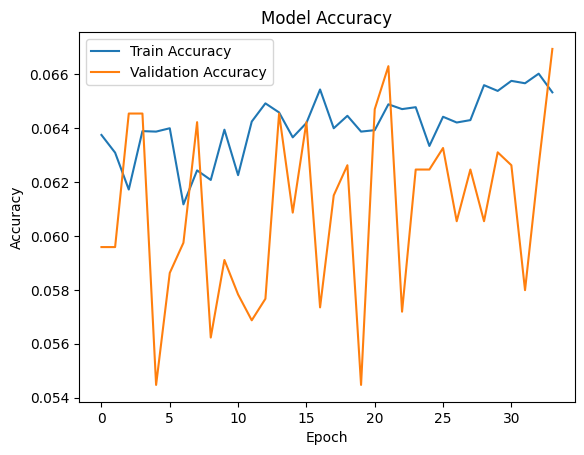

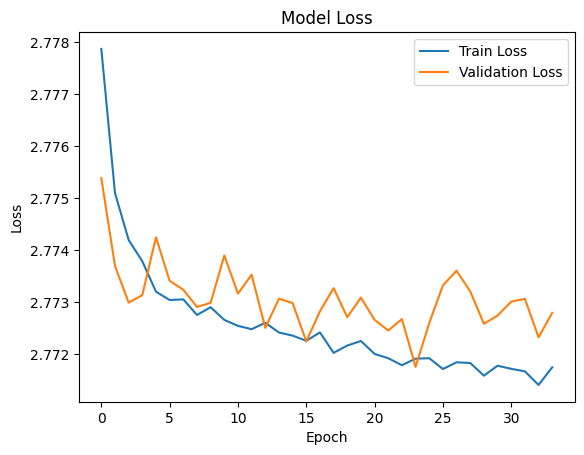

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()